# Forest Cover Type Prediction

Submitted by:
* Juanjo Carin
* Tuhin Mahmud
* Vamsi Sakhamuri

Date: July 16, 2015

Kaggle Competition hosted at https://www.kaggle.com/c/forest-cover-type-prediction

## Objectives: Use cartographic variables to classify forest categories

Random forests? Cover trees? Not so fast, computer nerds. We're talking about the real thing.

In this competition we are asked to predict the forest cover type (the predominant kind of tree cover) from strictly cartographic variables (as opposed to remotely sensed data). The actual forest cover type for a given 30 x 30 meter cell was determined from US Forest Service (USFS) Region 2 Resource Information System data. Independent variables were then derived from data obtained from the US Geological Survey and USFS. The data is in raw form (not scaled) and contains binary columns of data for qualitative independent variables such as wilderness areas and soil type.

This study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado. These areas represent forests with minimal human-caused disturbances, so that existing forest cover types are more a result of ecological processes rather than forest management practices.

## Loading and preparing the data

First we import the libraries we'll use along this project.

In [3]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

Next we load the training and test data sets.

In [4]:
ff = "train.csv" # you will need to edit this directory
f = open(ff)
column_names = f.readline() # you'd needs this ordinarily

data = np.loadtxt(f, delimiter=",")

y, X = data[:, -1], data[:, :-1]

ff_test = "test.csv" # you will need to edit this directory
f_test = open(ff_test)
column_names_test = f_test.readline() # you'd needs this ordinarily

data_test = np.loadtxt(f_test, delimiter=",")

# note there are no labels here!
X_test = data_test

print 'The test dataset contains {0} observations with {1} features each.'.\
    format(X_test.shape[0], X_test.shape[1])
print '\t(The 1st one is not really a feature but an observation ID.)'
print 'The training dataset contains {0} observations with the same {1} features each.'.\
    format(X.shape[0], X.shape[1])
print 'For this training set we know the corresponding category (forest cover type) of the ' \
      '{0} observations.'.format(y.shape[0])

The test dataset contains 565892 observations with 55 features each.
	(The 1st one is not really a feature but an observation ID.)
The training dataset contains 15120 observations with the same 55 features each.
For this training set we know the corresponding category (forest cover type) of the 15120 observations.


Note that the test set is about 37 times larger than the training set.

To evaluate our performance, we'll split the training set in 2 subsets: **training** data (80%) plus **development** (aka **validation**) data (20%). **Test** data *must not* be used to validate our models, otherwise we might introduce bias: the more times we look at the error rate on the test set , the more we know about the test data, and the more we include our knowledge (that's very specific to that test data set) in the way we solve the problem.

> Nonetheless, in most cases we'll use *cross-validation* to assess how the results of one model generalize to another data set: with this model validation technique, the training data are partitioned into complementary subsets, multiple rounds of cross-validation are performed using different partitions, and the results are averaged.

We also discard the 1st variable (ID), which does not provide any information about the forest cover type.

In [5]:
train_size = int(X.shape[0] * 0.8)
y_train, X_train = y[:train_size], X[:train_size, 1:]
y_dev, X_dev = y[train_size:], X[train_size:, 1:]
X_test = X_test[:, 1:]
print X_dev.shape, X_train.shape

(3024L, 54L) (12096L, 54L)


The first 10 features of each observation (`Elevation` to `Horizontal_Distance_To_Fire_Points`) are continuous, with different ranges, while the remaining 44 are all binary.

We'll try `preprocessing.StandardScaler` (standardize features by removing the mean and scaling to unit variance) as well as `preprocessing.MinMaxScaler` (standardizes features by scaling each feature to a given range; e.g., [0,1]). We could also try to binarize also those 10 features, using `preprocessing.binarize`, but the appropriate thresholds are unknown, and we'd lose information about the variability of those features.

http://scikit-learn.org/stable/modules/preprocessing.html

In [6]:
from sklearn import preprocessing

# Scale to range [0,1]
min_max_scaler = preprocessing.MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(X_train)
X_dev_minmax = min_max_scaler.transform(X_dev)
X_test_minmax = min_max_scaler.transform(X_test)

# Scale to mean = 0, sd = 1
std_scaler = preprocessing.StandardScaler()
X_train_std = std_scaler.fit_transform(X_train)
X_dev_std = std_scaler.transform(X_dev)
X_test_std = std_scaler.transform(X_test)

## k-Nearest Neighbors (kNN)

8


(0, 65)

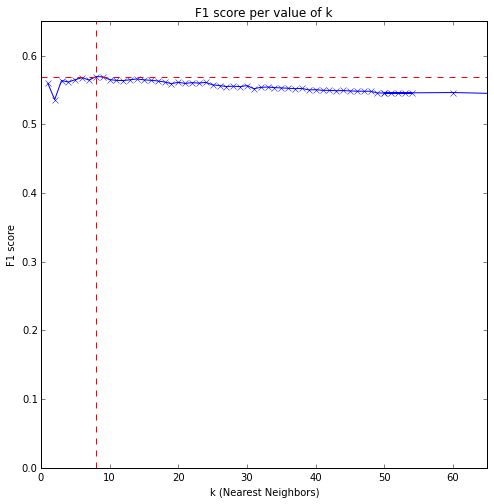

In [35]:
k = {'n_neighbors': np.concatenate([np.arange(1, X_train_std.shape[1]+1), 
                                    np.arange(50, 100, 10), np.arange(100,201,25)]).tolist()}
best_param_kNN = GridSearchCV(KNeighborsClassifier(), k, scoring='f1_macro')
best_param_kNN.fit(X_train_std, y_train)
optimal_k = best_param_kNN.best_params_['n_neighbors']
print optimal_k

f1_vector = np.array([best_param_kNN.grid_scores_[x][1] for x in 
                      range(len(k['n_neighbors']))])
plt.figure(figsize=(8, 8))
plt.plot(k['n_neighbors'], f1_vector, marker='x')
plt.axvline(x=optimal_k, linewidth=1, linestyle='--', color='red')
plt.axhline(y=best_param_kNN.best_score_, linewidth=1, linestyle='--', color='red')
plt.xlabel("k (Nearest Neighbors)")
plt.ylabel("F1 score")
plt.title('F1 score per value of k')
plt.ylim([0, (np.ceil(best_param_kNN.best_score_*20)+1)/20])
plt.xlim([0, len(k['n_neighbors'])+1])

How well does our first model perform on the development data?

In [36]:
k = optimal_k
kNN = KNeighborsClassifier(n_neighbors=k)

kNN.fit(X_train, y_train)
print 'Accuracy using k = {0} neighbor(s) and non-scaled data:      {1:.4f}'.\
    format(k, kNN.score(X_dev, y_dev))
print 'F1 score using k = {0} neighbor(s) and non-scaled data:      {1:.4f}'.\
    format(k, metrics.f1_score(y_true=y_dev, y_pred=kNN.predict(X_dev), average='macro'))

kNN.fit(X_train_std, y_train)
print 'Accuracy using k = {0} neighbor(s) and standardized data:    {1:.4f}'.\
    format(k, kNN.score(X_dev_std, y_dev))
print 'F1 score using k = {0} neighbor(s) and standardized data:    {1:.4f}'.\
    format(k, metrics.f1_score(y_true=y_dev, y_pred=kNN.predict(X_dev_std), average='macro'))

kNN.fit(X_train_minmax, y_train)
print 'Accuracy using k = {0} neighbor(s) and scaled-to-range data: {1:.4f}'.\
    format(k, kNN.score(X_dev_minmax, y_dev))
print 'F1 score using k = {0} neighbor(s) and scaled-to-range data: {1:.4f}'.\
    format(k, metrics.f1_score(y_true=y_dev, y_pred=kNN.predict(X_dev_minmax), 
                               average='macro'))

Accuracy using k = 8 neighbor(s) and non-scaled data:      0.7963
F1 score using k = 8 neighbor(s) and non-scaled data:      0.7639
Accuracy using k = 8 neighbor(s) and standardized data:    0.7596
F1 score using k = 8 neighbor(s) and standardized data:    0.7259
Accuracy using k = 8 neighbor(s) and scaled-to-range data: 0.7685
F1 score using k = 8 neighbor(s) and scaled-to-range data: 0.7388


## Results

Here's what we need to send back to Kaggle:

In [ ]:
preds = kNN.predict(X_test)
print preds

Finally we'd  need to save the output to a textfile, and upload the results to kaggle (see https://www.kaggle.com/c/digit-recognizer/data for further information).

In [14]:
kNN.fit(X_train_minmax, y_train)
preds = kNN.predict(X_test_minmax)

In [16]:
test_lab_f = open("test_labeled_range.csv", "w") # you will need to edit this directory

test_lab_f.write("Id,Cover_Type")

idx = X.shape[0]
                 
for pp in preds:
    idx += 1
    test_lab_f.write("\n")
    test_lab_f.write(str(idx) + "," + str(int(pp)))
   
test_lab_f.close()

## Appendix 1: Plotting the training dataset

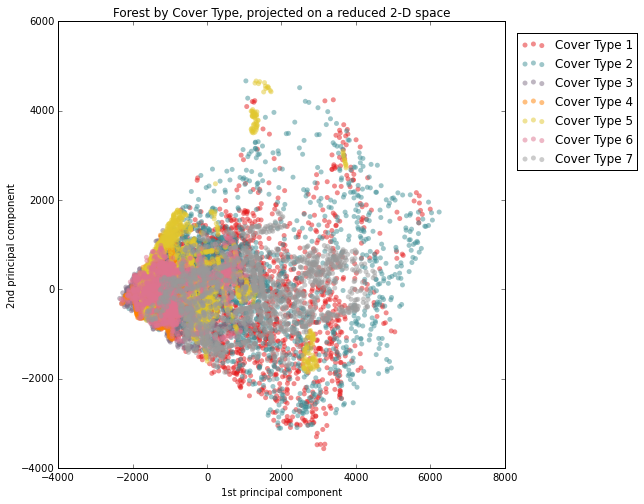

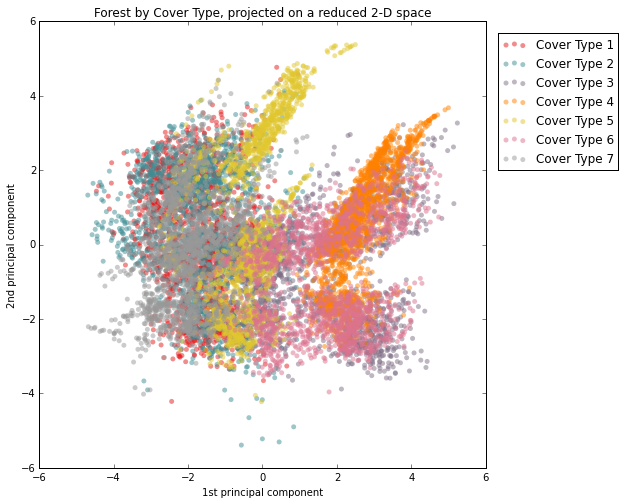

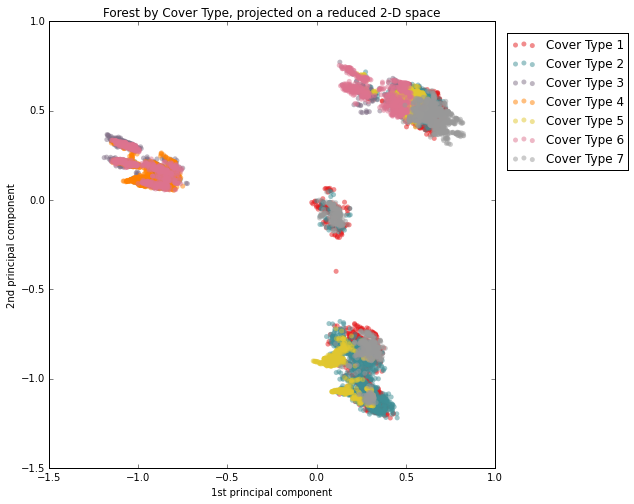

In [68]:
def plot(dataset):
    from sklearn.decomposition import PCA
    pc_2 = PCA(n_components=2)
    # Transform the coordinates into this new 2-D space
    X_train_2pc = pc_2.fit_transform(dataset)
    # Plot all elements of the training set in this 2-D space
    # Plot the projection of each forest in a 2-D space, with a color corresponding to each cover
        # type
    Colors = plt.cm.Set1(np.linspace(0, 1, int(np.ptp(y_train)+1)))
    # Each color is represented by 4 RGBA coordinates
    # cover_color = np.empty(4*X_train_2pc.shape[0]).reshape(X_train_2pc .shape[0], 4)
    # for i in np.arange(y_train.shape[0]):
        # color_index = y_train[i]-1
        # Each color is indexed by the cover type
        # cover_color[i,:] = Colors[color_index]
    plt.figure  (figsize = (8, 8))
    cover = np.empty(int(np.ptp(y_train)+1)).tolist()
    for i in range(int(np.ptp(y_train)+1)):
        cover[i] = plt.scatter (X_train_2pc[y_train==i+1,0], X_train_2pc[y_train==i+1,1],
                                c = Colors[i], alpha = 0.5, s=25, edgecolor='',
                                label = 'Cover Type ' + str(i+1))
    plt.xlabel("1st principal component")
    plt.ylabel("2nd principal component")
    plt.title('Forest by Cover Type, projected on a reduced 2-D space')
    plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=1.)

plot(X_train)
plot(X_train_std)
plot(X_train_minmax)